<h1><center> Massive Data Fundamental Final Project <br><br>
    <Center> Exploratory Data Analysis  <br><br>
    <center> Ann Lian, Yuhan Ma, Wendy Shi

# TOC

- [Load Data](#Load-Data)
- [EDA](#EDA)
- [Geo-Spatial](#Geo-Spatial-Analysis)

# Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Load Data
Note that we save the processed dataframe from cloud, and run EDA locally

In [2]:
Processed = pd.read_csv("../Data/Processed.csv")
Processed.drop(columns = 'Unnamed: 0', inplace = True)
Processed.head(3)

PULocationID          pickup_hour  Count  is_holiday  hour  dayofweek  \
0             4  2024-08-01 00:00:00      2           0     0          3   
1             4  2024-08-01 01:00:00      6           0     1          3   
2             4  2024-08-01 02:00:00      2           0     2          3   

   is_weekend  lag_1h  lag_24h  lag_1w  ...  zone_237  zone_238  zone_239  \
0           0     0.0      0.0     0.0  ...         0         0         0   
1           0     2.0      0.0     0.0  ...         0         0         0   
2           0     6.0      0.0     0.0  ...         0         0         0   

   zone_243  zone_244  zone_246  zone_249  zone_261  zone_262  zone_263  
0         0         0         0         0         0         0         0  
1         0         0         0         0         0         0         0  
2         0         0         0         0         0         0         0  

[3 rows x 77 columns]

# EDA

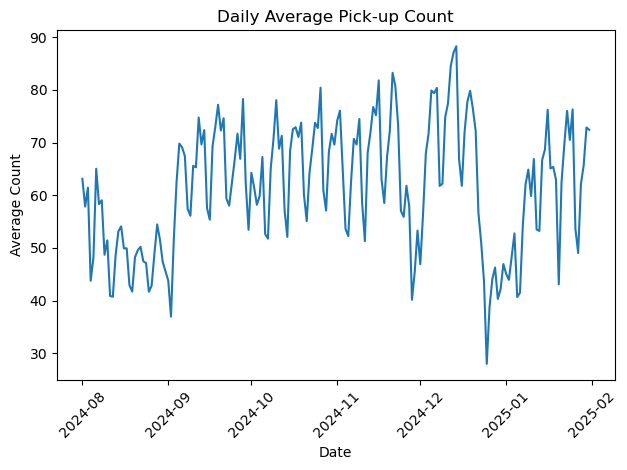

In [22]:
Processed['date'] = pd.to_datetime(Processed['pickup_hour']).dt.date
daily_avg = Processed.groupby('date')['Count'].mean().reset_index()

# Plot
import matplotlib.pyplot as plt
plt.plot(daily_avg['date'], daily_avg['Count'])
plt.title('Daily Average Pick-up Count')
plt.xlabel('Date')
plt.ylabel('Average Count')
plt.xticks(rotation=45)
plt.tight_layout()

#plt.savefig("daily_avg.png") 
plt.show()

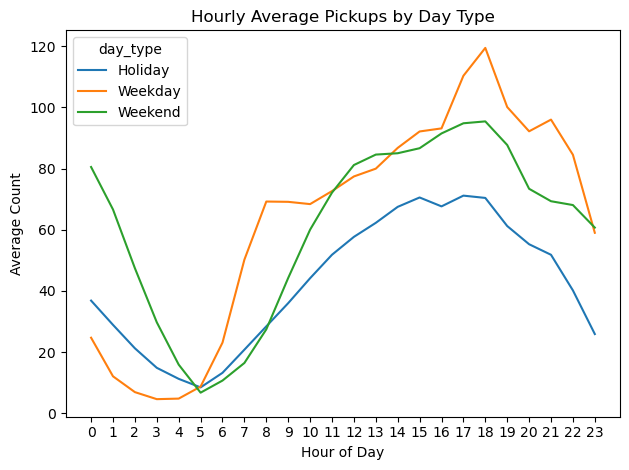

In [20]:
def get_day_type(row):
    if row['is_holiday']:
        return 'Holiday'
    elif row['is_weekend']:
        return 'Weekend'
    else:
        return 'Weekday'

Processed['day_type'] = Processed.apply(get_day_type, axis=1)
hourly_avg = Processed.groupby(['hour', 'day_type'])['Count'].mean().reset_index()

# Plot
import seaborn as sns
sns.lineplot(data=hourly_avg, x='hour', y='Count', hue='day_type')
plt.title('Hourly Average Pickups by Day Type')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.xticks(range(0, 24))
plt.tight_layout()

#plt.savefig("hourly_avg.png") 
plt.show()

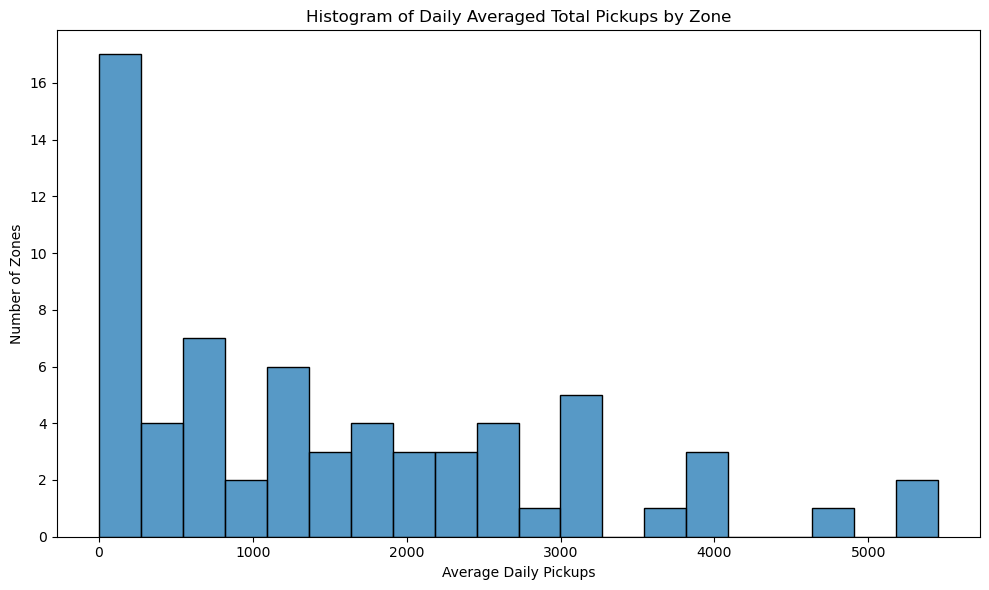

In [19]:
import pandas as pd

# Find zone columns
zone_cols = [col for col in Processed.columns if col.startswith('zone_')]

# Identify the active zone per row (the one with value 1)
Processed['zone'] = Processed[zone_cols].idxmax(axis=1)  # e.g., 'zone_243'
Processed['zone'] = Processed['zone'].str.replace('zone_', '').astype(int)

# Convert pickup time to date
Processed['date'] = pd.to_datetime(Processed['pickup_hour']).dt.date

# Sum pickups by zone per day
daily_zone = Processed.groupby(['zone', 'date'])['Count'].sum().reset_index()

# Average pickups per zone across all days
zone_daily_avg = daily_zone.groupby('zone')['Count'].mean().reset_index()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(zone_daily_avg['Count'], bins=20)
plt.title('Histogram of Daily Averaged Total Pickups by Zone')
plt.xlabel('Average Daily Pickups')
plt.ylabel('Number of Zones')
plt.tight_layout()

#plt.savefig("pickup_count_density.png") 
plt.show()

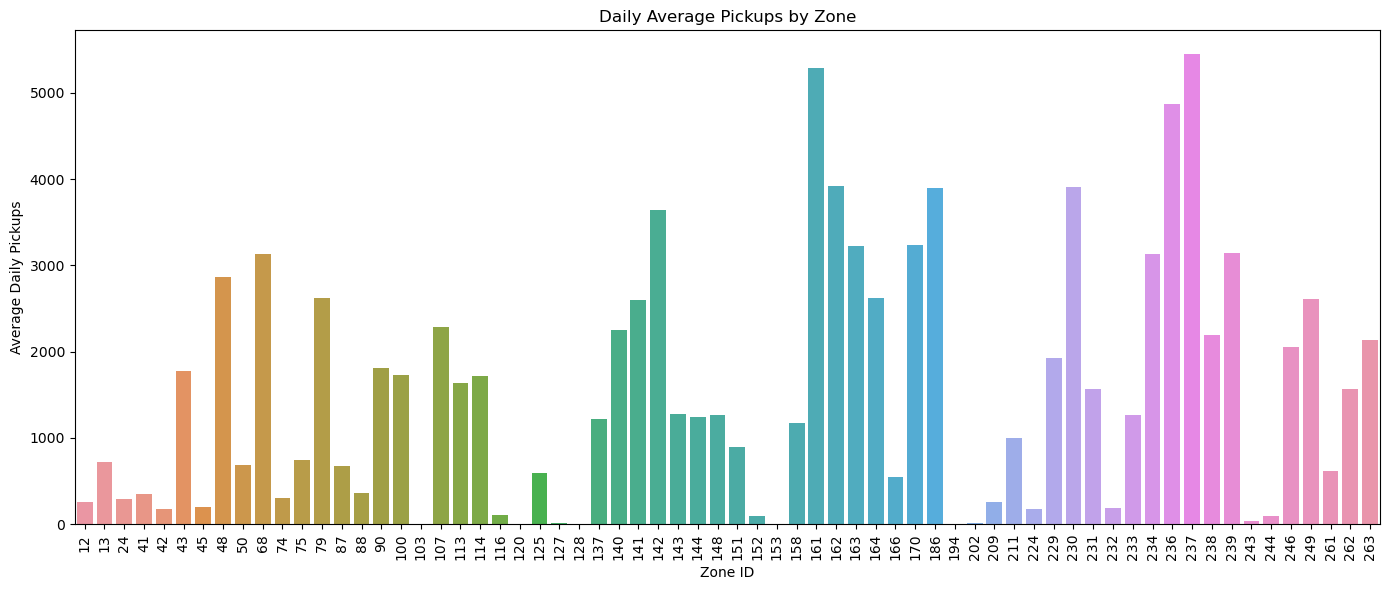

In [18]:
plt.figure(figsize=(14, 6))
sns.barplot(data=zone_daily_avg, x='zone', y='Count')
plt.title('Daily Average Pickups by Zone')
plt.xlabel('Zone ID')
plt.ylabel('Average Daily Pickups')
plt.xticks(rotation=90)
plt.tight_layout()

#plt.savefig("zone_daily.png") 
plt.show()

In [13]:
# Filter for weekdays and time
Processed['hour'] = pd.to_datetime(Processed['pickup_hour']).dt.hour
Processed['dayofweek'] = pd.to_datetime(Processed['pickup_hour']).dt.dayofweek
weekday_4to9pm = Processed[(Processed['dayofweek'] < 5) & (Processed['hour'] >= 16) & (Processed['hour'] < 21)].copy()

# Identify zone per row
zone_cols = [col for col in weekday_4to9pm.columns if col.startswith('zone_')]
weekday_4to9pm['zone'] = weekday_4to9pm[zone_cols].idxmax(axis=1).str.replace('zone_', '').astype(int)


zone_avg_4to9pm = (
    weekday_4to9pm.groupby('zone')['Count']
    .mean()
    .reset_index()
    .sort_values(by='Count', ascending=False)
)

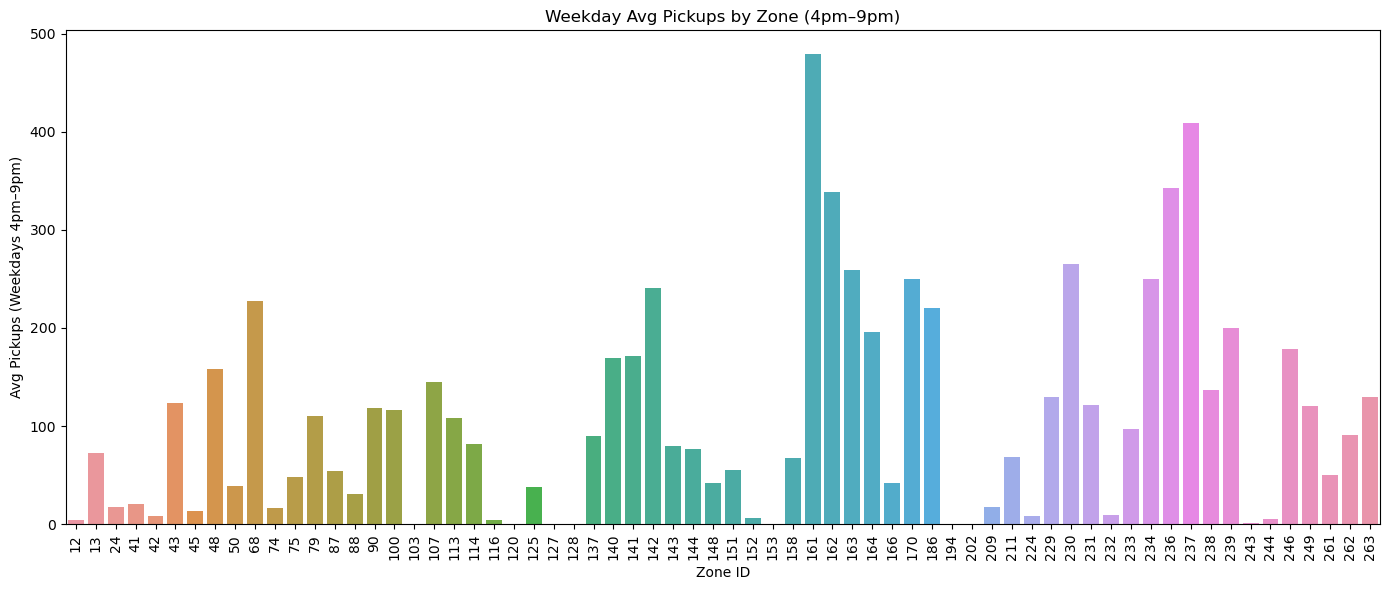

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.barplot(data=zone_avg_4to9pm, x='zone', y='Count')
plt.title('Weekday Avg Pickups by Zone (4pm–9pm)')
plt.xlabel('Zone ID')
plt.ylabel('Avg Pickups (Weekdays 4pm–9pm)')
plt.xticks(rotation=90)
plt.tight_layout()

#plt.savefig("zone_4to9.png") 
plt.show()

# Geo-Spatial Analysis

## Shapefile Data

In [24]:
zones_gdf = gpd.read_file("../Data/taxi_zones/taxi_zones.shp")
zones_gdf.tail(3)

OBJECTID  Shape_Leng  Shape_Area                zone  LocationID  \
260       261    0.027120    0.000034  World Trade Center         261   
261       262    0.049064    0.000122      Yorkville East         262   
262       263    0.037017    0.000066      Yorkville West         263   

       borough                                           geometry  
260  Manhattan  POLYGON ((980555.204 196138.486, 980570.792 19...  
261  Manhattan  MULTIPOLYGON (((999804.795 224498.527, 999824....  
262  Manhattan  POLYGON ((997493.323 220912.386, 997355.264 22...

In [25]:
Manh = zones_gdf[zones_gdf['borough'] == 'Manhattan']
Manh_list = Manh['LocationID'].tolist()
print(Manh.shape)
Manh.head(3)

(69, 7)


OBJECTID  Shape_Leng  Shape_Area               zone  LocationID  \
3          4    0.043567    0.000112      Alphabet City           4   
11        12    0.036661    0.000042       Battery Park          12   
12        13    0.050281    0.000149  Battery Park City          13   

      borough                                           geometry  
3   Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
11  Manhattan  POLYGON ((979908.772 196066.565, 979980.852 19...  
12  Manhattan  POLYGON ((980801.310 201248.869, 980697.386 20...

# Visualization

In [26]:
# 184 day for half a year
total_pick_up = Processed.groupby("PULocationID").sum('Count').reset_index()
total_pick_up = total_pick_up[['PULocationID', 'Count']].copy()

total_pick_up['daily_avg'] = total_pick_up['Count']/184
total_pick_up['daily_avg'] = total_pick_up['daily_avg'].astype('int')

rename = {'PULocationID' : 'LocationID'}
total_pick_up = total_pick_up.rename(columns = rename)
total_pick_up.head(3)

LocationID   Count  daily_avg
0           4   39254        213
1          12    8308         45
2          13  132373        719

In [27]:
zones_gdf.head(3)

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   

  borough                                           geometry  
0     EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1  Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2   Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...

In [28]:
merged = pd.merge(total_pick_up, zones_gdf, on = 'LocationID', how = 'inner')
merged.head(3)

LocationID   Count  daily_avg  OBJECTID  Shape_Leng  Shape_Area  \
0           4   39254        213         4    0.043567    0.000112   
1          12    8308         45        12    0.036661    0.000042   
2          13  132373        719        13    0.050281    0.000149   

                zone    borough  \
0      Alphabet City  Manhattan   
1       Battery Park  Manhattan   
2  Battery Park City  Manhattan   

                                            geometry  
0  POLYGON ((992073.467 203714.076, 992068.667 20...  
1  POLYGON ((979908.772 196066.565, 979980.852 19...  
2  POLYGON ((980801.310 201248.869, 980697.386 20...

In [29]:
gdf = merged[['geometry','zone','LocationID', 'daily_avg']].copy()
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.head(3)

geometry               zone  \
0  POLYGON ((992073.467 203714.076, 992068.667 20...      Alphabet City   
1  POLYGON ((979908.772 196066.565, 979980.852 19...       Battery Park   
2  POLYGON ((980801.310 201248.869, 980697.386 20...  Battery Park City   

   LocationID  daily_avg  
0           4        213  
1          12         45  
2          13        719

In [30]:
subset = gdf[gdf['LocationID'].isin([161, 186, 142, 237, 79, 194, 153, 128, 103, 120])].copy()
subset

geometry  \
13  POLYGON ((988746.067 202151.955, 988733.885 20...   
18  POLYGON ((972079.575 190732.429, 972184.766 19...   
19  POLYGON ((973172.666 194632.348, 973310.630 19...   
20  POLYGON ((979605.759 191880.575, 979978.435 19...   
25  POLYGON ((1005562.335 252189.432, 1005597.841 ...   
28  MULTIPOLYGON (((1005378.119 259493.528, 100537...   
32  POLYGON ((989380.305 218980.247, 989359.803 21...   
38  POLYGON ((1010061.703 258338.334, 1009990.141 ...   
40  POLYGON ((991081.026 214453.698, 990952.644 21...   
46  POLYGON ((986752.603 210853.699, 986627.863 21...   
47  POLYGON ((1007397.115 229906.118, 1007658.653 ...   
59  POLYGON ((993633.442 216961.016, 993507.232 21...   

                                             zone  LocationID  daily_avg  
13                                   East Village          79       2618  
18  Governor's Island/Ellis Island/Liberty Island         103          0  
19  Governor's Island/Ellis Island/Liberty Island         103          0  
20  Governor's Island/Ellis Island/Liberty Island         103          0  
25                                Highbridge Park         120          0  
28                               Inwood Hill Park         128          1  
32                            Lincoln Square East         142       3647  
38                                    Marble Hill         153          2  
40                                 Midtown Center         161       5291  
46                   Penn Station/Madison Sq West         186       3900  
47                                Randalls Island         194          5  
59                          Upper East Side South         237       5453

In [31]:
print(gdf.crs)

EPSG:2263


In [32]:
gdf['daily_avg'] = gdf['daily_avg'].fillna(0)

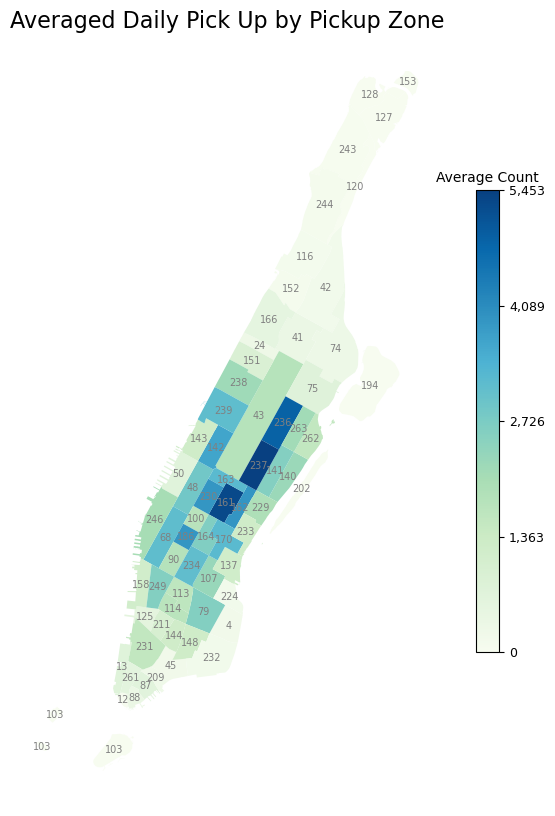

In [33]:
# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
plot = gdf.plot(column='daily_avg',
                cmap='GnBu',
                linewidth=0.1,
                ax=ax)

# Add colorbar
cbar = fig.colorbar(plot.collections[0], ax=ax, shrink=0.6)

# Ticks
min_val = gdf['daily_avg'].min()
max_val = gdf['daily_avg'].max()
ticks = np.linspace(min_val, max_val, 5)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(tick):,}" for tick in ticks])
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_title("Average Count", fontsize=10)

# Add LocationID labels at the centroid of each polygon
for idx, row in gdf.iterrows():
    if row['geometry'].geom_type == 'Polygon' or row['geometry'].geom_type == 'MultiPolygon':
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, str(row['LocationID']),
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=7, color='gray')

# Title
ax.set_title("Averaged Daily Pick Up by Pickup Zone", fontsize=16)
ax.axis('off')

fig.savefig("CBG_daily_avg.png", dpi=300, bbox_inches='tight')

plt.show()


# Weekday 4 - 9

In [35]:
Processed.head(3)

PULocationID          pickup_hour  Count  is_holiday  hour  dayofweek  \
0             4  2024-08-01 00:00:00      2           0     0          3   
1             4  2024-08-01 01:00:00      6           0     1          3   
2             4  2024-08-01 02:00:00      2           0     2          3   

   is_weekend  lag_1h  lag_24h  lag_1w  ...  zone_243  zone_244  zone_246  \
0           0     0.0      0.0     0.0  ...         0         0         0   
1           0     2.0      0.0     0.0  ...         0         0         0   
2           0     6.0      0.0     0.0  ...         0         0         0   

   zone_249  zone_261  zone_262  zone_263        date  day_type  zone  
0         0         0         0         0  2024-08-01   Weekday    12  
1         0         0         0         0  2024-08-01   Weekday    12  
2         0         0         0         0  2024-08-01   Weekday    12  

[3 rows x 80 columns]

In [39]:
hour_list = [16, 17, 18, 19, 20, 21]
Processed_sub = Processed[(Processed['is_weekend']!= 1)&(Processed['hour'].isin(hour_list))].copy()

In [41]:
Processed_sub['pickup_hour'] = pd.to_datetime(Processed_sub['pickup_hour'])
Processed_sub['date'] = Processed_sub['pickup_hour'].dt.date
unique_day = Processed_sub['date'].unique().tolist()
print(len(unique_day))
#Processed_sub.head()

132


In [42]:
# 184 day for half a year
total_pick_up = Processed_sub.groupby("PULocationID").sum('Count').reset_index()
total_pick_up = total_pick_up[['PULocationID', 'Count']].copy()

total_pick_up['daily_avg'] = total_pick_up['Count']/132
total_pick_up['daily_avg'] = total_pick_up['daily_avg'].astype('int')

rename = {'PULocationID' : 'LocationID'}
total_pick_up = total_pick_up.rename(columns = rename)
total_pick_up.head(3)

LocationID  Count  daily_avg
0           4   4850         36
1          12   1887         14
2          13  53810        407

In [43]:
merged = pd.merge(total_pick_up, zones_gdf, on = 'LocationID', how = 'inner')
gdf = merged[['geometry', 'LocationID', 'daily_avg']].copy()
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.head(3)

geometry  LocationID  daily_avg
0  POLYGON ((992073.467 203714.076, 992068.667 20...           4         36
1  POLYGON ((979908.772 196066.565, 979980.852 19...          12         14
2  POLYGON ((980801.310 201248.869, 980697.386 20...          13        407

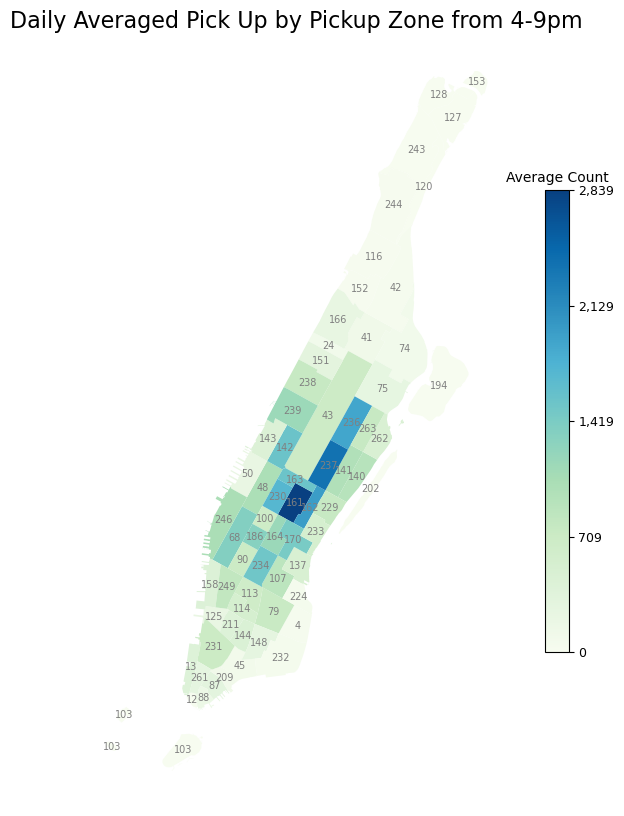

In [44]:
# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
plot = gdf.plot(column='daily_avg',
                cmap='GnBu',
                linewidth=0.1,
                ax=ax)

# Add colorbar
cbar = fig.colorbar(plot.collections[0], ax=ax, shrink=0.6)

# Ticks
min_val = gdf['daily_avg'].min()
max_val = gdf['daily_avg'].max()
ticks = np.linspace(min_val, max_val, 5)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{int(tick):,}" for tick in ticks])
cbar.ax.tick_params(labelsize=9)
cbar.ax.set_title("Average Count", fontsize=10)

# Add LocationID labels at the centroid of each polygon
for idx, row in gdf.iterrows():
    if row['geometry'].geom_type == 'Polygon' or row['geometry'].geom_type == 'MultiPolygon':
        centroid = row['geometry'].centroid
        ax.text(centroid.x, centroid.y, str(row['LocationID']),
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=7, color='gray')

# Title
ax.set_title("Daily Averaged Pick Up by Pickup Zone from 4-9pm", fontsize=16)
ax.axis('off')

#fig.savefig("CBG_daily_avg_4-9pm.png", dpi=300, bbox_inches='tight')

plt.show()
